In [ ]:
!pip install filterpy

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import Optional, Tuple
from filterpy.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints, EnsembleKalmanFilter

In [ ]:
class L96Simulator:
    def __init__(self, Q: torch.Tensor, H: torch.Tensor, R: torch.Tensor,
                 F: float = 8.0, dt: float = 0.01, substeps: int = 1,
                 p: float = 1.5, eps: float = 1e-6, compile_step: bool = True):
        self.Q, self.H, self.R = Q, H, R
        self.device, self.dtype = Q.device, Q.dtype
        self.N, self.M = Q.shape[0], H.shape[0]
        self.F, self.dt, self.sub = float(F), float(dt), int(substeps)
        self.p, self.eps = float(p), float(eps)

        # Precompute Cholesky factors for fast Gaussian sampling
        # (equivalent to using MultivariateNormal with scale_tril)
        self.LQ = torch.linalg.cholesky(Q)  # (N,N)
        self.LR = torch.linalg.cholesky(R)  # (M,M)

        # Precompute index buffers for cyclic neighbors (avoid torch.roll each time)
        idx = torch.arange(self.N, device=self.device)
        self.idx_p1 = (idx + 1) % self.N
        self.idx_m1 = (idx - 1) % self.N
        self.idx_m2 = (idx - 2) % self.N

        # Optionally compile the per-substep RK4 integrator (PyTorch 2.x)
        step_fn = self._rk4_once
        if compile_step:
            try:
                step_fn = torch.compile(self._rk4_once)  # no-op on older versions
            except Exception:
                pass
        self._rk4_once_compiled = step_fn

    # vectorized RHS using index-buffers (no torch.roll)
    def _rhs(self, x):  # x: (B,N)
        xp1 = x[..., self.idx_p1]
        xm1 = x[..., self.idx_m1]
        xm2 = x[..., self.idx_m2]
        return (xp1 - xm2) * xm1 - x + self.F

    # one RK4 step of size (dt/sub)
    def _rk4_once(self, x):
        h  = self.dt / self.sub
        k1 = self._rhs(x)
        k2 = self._rhs(x + 0.5 * h * k1)
        k3 = self._rhs(x + 0.5 * h * k2)
        k4 = self._rhs(x + h * k3)
        return x + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    # signed-power nonlinearity
    def _signed_pow(self, z):
        return torch.sign(z) * (z.abs().clamp_min(self.eps) ** self.p)

    @torch.no_grad()
    def __call__(self, T: int, B: int, device):
        # States and outputs
        X = torch.empty(B, T, self.N, device=self.device, dtype=self.dtype)
        Y = torch.empty(B, T, self.M, device=self.device, dtype=self.dtype)
        x0 = torch.randn(B, self.N, device=self.device, dtype=self.dtype)

        # Pre-sample all process/measurement noise via Cholesky factors
        # W ~ N(0,Q): eps @ LQ^T;  V ~ N(0,R): eps @ LR^T
        eps_W = torch.randn(B, T, self.N, device=self.device, dtype=self.dtype)
        W = eps_W @ self.LQ.T
        eps_V = torch.randn(B, T, self.M, device=self.device, dtype=self.dtype)
        V = eps_V @ self.LR.T

        # Integrate sequentially; substeps fused; kernel compiled if available
        x = x0
        for t in range(T):
            for _ in range(self.sub):
                x = self._rk4_once_compiled(x)
            x = x + W[:, t]              # process noise
            X[:, t] = x
            z = X[:, t] @ self.H.T       # (B,M)
            Y[:, t] = self._signed_pow(z) + V[:, t]

        return X, Y, x0

In [ ]:
class ExtendedKalmanFilterL96:
    def __init__(self, dt, F, H, Q, R, P0, p=1.5, eps=1e-6):
        self.dt, self.F_forcing = float(dt), float(F)
        self.H  = np.asarray(H, dtype=float, order='C')
        self.Q  = np.asarray(Q, dtype=float, order='C')
        self.R  = np.asarray(R, dtype=float, order='C')
        self.P0 = np.asarray(P0, dtype=float, order='C')
        self.N  = self.Q.shape[0]
        self.M  = self.R.shape[0]
        self.p, self.eps = float(p), float(eps)
        # Precompute identity for Jacobian build
        self._I = np.eye(self.N, dtype=float)

    # ---------- L96 RHS (vectorized on leading batch axis) ----------
    def _rhs_batch(self, X):  # X:(B,N)
        xp1 = np.roll(X, -1, axis=-1)
        xm1 = np.roll(X,  1, axis=-1)
        xm2 = np.roll(X,  2, axis=-1)
        return (xp1 - xm2) * xm1 - X + self.F_forcing

    def _rk4_step_batch(self, X):  # X:(B,N)
        dt = self.dt
        k1 = self._rhs_batch(X)
        k2 = self._rhs_batch(X + 0.5*dt*k1)
        k3 = self._rhs_batch(X + 0.5*dt*k2)
        k4 = self._rhs_batch(X + dt*k3)
        return X + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    # ---------- Build F_k = I + dt * J_c(x) for all sequences at once ----------
    def _F_jacobian_batch(self, X):  # X:(B,N) -> F:(B,N,N)
        B, N = X.shape
        Fk = np.zeros((B, N, N), dtype=float)
        # indices for the 4 nonzero columns in each row (cyclic)
        idx = np.arange(N)
        im1 = (idx - 1) % N
        ip1 = (idx + 1) % N
        im2 = (idx - 2) % N

        # Fill diagonal blocks row-wise using advanced indexing
        # J[i,i]   = -1
        Fk[:, idx, idx] = 1.0 + self.dt * (-1.0)
        # J[i,im1] = (x[ip1] - x[im2])
        Fk[:, idx, im1] += self.dt * (X[:, ip1] - X[:, im2])
        # J[i,ip1] =  x[im1]
        Fk[:, idx, ip1] += self.dt * (X[:, im1])
        # J[i,im2] = -x[im1]
        Fk[:, idx, im2] += self.dt * (-X[:, im1])

        return Fk  # shape (B,N,N)

    # ---------- Measurement: g(z)=sgn(z)|z|^p, z=H x ----------
    def _signed_pow(self, z):
        return np.sign(z) * np.power(np.maximum(np.abs(z), self.eps), self.p)

    def _signed_pow_grad(self, z):
        return self.p * np.power(np.maximum(np.abs(z), self.eps), self.p - 1.0)

    # FilterPy callbacks (work on column vectors)
    def _hx(self, x_col):
        x = np.asarray(x_col).reshape(-1)
        return self._signed_pow(self.H @ x).reshape(-1, 1)

    def _H_jacobian(self, x_col):
        x = np.asarray(x_col).reshape(-1)
        z = self.H @ x
        gprime = self._signed_pow_grad(z)          # (M,)
        return (gprime[:, None]) * self.H          # (M,N)

    # ---------- Public API ----------
    def __call__(self, Y, x0):
        Y  = np.asarray(Y,  dtype=float, order='C')  # (B,T,M)
        x0 = np.asarray(x0, dtype=float, order='C')  # (B,N)
        B, T, M = Y.shape
        N = self.N

        Xhat  = np.empty((B, T, N),    dtype=float)
        P_all = np.empty((B, T, N, N), dtype=float)
        K_all = np.empty((B, T, N, M), dtype=float)
        S_all = np.empty((B, T, M, M), dtype=float)
        Innov = np.empty((B, T, M),    dtype=float)

        # Pre-create EKF objects to avoid reallocation in large batches
        ekfs = []
        for b in range(B):
            ekf = ExtendedKalmanFilter(dim_x=N, dim_z=M)
            ekf.x = x0[b].reshape(N, 1)
            ekf.P = self.P0.copy()
            ekf.Q = self.Q
            ekf.R = self.R
            ekfs.append(ekf)

        # Work buffers
        x = x0.copy()                              # (B,N)

        for t in range(T):
            # ---- Batched nonlinear predict (vectorized) ----
            x_pred = self._rk4_step_batch(x)       # (B,N)
            Fk     = self._F_jacobian_batch(x)     # (B,N,N) uses x (linearize at prior)
            x = x_pred                              # roll state for next step

            # ---- Per-seq covariance predict + EKF update (FilterPy) ----
            z_t = Y[:, t]                           # (B,M)
            for b, ekf in enumerate(ekfs):
                # predict: x, P
                ekf.x[:] = x_pred[b].reshape(N, 1)
                P = ekf.P
                Fb = Fk[b]
                ekf.P = Fb @ P @ Fb.T + ekf.Q

                # update: uses FilterPy implementation (S, K, y stored internally)
                ekf.update(z=z_t[b].reshape(M, 1),
                           HJacobian=self._H_jacobian,
                           Hx=self._hx)

                # save
                Xhat[b, t]  = ekf.x.reshape(-1)
                P_all[b, t] = ekf.P
                S_all[b, t] = ekf.S
                K_all[b, t] = ekf.K
                Innov[b, t] = ekf.y.reshape(-1)

        return Xhat, P_all, K_all, Innov, S_all

In [ ]:
class UnscentedKalmanFilterL96:
  #https://groups.seas.harvard.edu/courses/cs281/papers/unscented.pdf
    """
    Fast UKF for Lorenz-96 with signed-power sensor g(z)=sgn(z)|z|^p.
    Uses FilterPy UKF for the Bayes step; optimizes everything else.
    - Reuses per-sequence UKF objects across calls
    - Shares sigma-points object
    - Optional logging (skip P/K/S/Innov if not needed)
    """
    def __init__(self,
                 dt, F, H, Q, R, P0,
                 p=1.5, eps=1e-6,
                 alpha=1e-3, beta=2.0, kappa=0.0,
                 dtype=np.float32):
        self.dt  = float(dt)
        self.F   = float(F)
        self.H   = np.asarray(H, dtype=dtype, order='C')   # (M,N)
        self.Q   = np.asarray(Q, dtype=dtype, order='C')   # (N,N)
        self.R   = np.asarray(R, dtype=dtype, order='C')   # (M,M)
        self.P0  = np.asarray(P0, dtype=dtype, order='C')  # (N,N)
        self.N   = self.Q.shape[0]
        self.M   = self.R.shape[0]
        self.p   = float(p)
        self.eps = float(eps)
        self.dtype = dtype

        # Single sigma-points generator reused by all UKFs
        self.points = MerweScaledSigmaPoints(
            n=self.N, alpha=alpha, beta=beta, kappa=kappa
        )

        # Cache UKF objects between calls
        self._filters = None

        # Bind helpers as locals (slightly faster lookups)
        self._fx = self._fx_single
        self._hx = self._hx_single

    # --------- L96 dynamics (vectorized) ----------
    @staticmethod
    def _rhs_batch(X, F):
        xp1 = np.roll(X, -1, axis=-1)
        xm1 = np.roll(X,  1, axis=-1)
        xm2 = np.roll(X,  2, axis=-1)
        return (xp1 - xm2) * xm1 - X + F

    @classmethod
    def _rk4_step_batch(cls, X, dt, F):
        k1 = cls._rhs_batch(X, F)
        k2 = cls._rhs_batch(X + 0.5*dt*k1, F)
        k3 = cls._rhs_batch(X + 0.5*dt*k2, F)
        k4 = cls._rhs_batch(X + dt*k3,     F)
        return X + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    # FilterPy signatures: fx(x, dt) -> (N,), hx(x) -> (M,)
    def _fx_single(self, x, dt):
        X = self._rk4_step_batch(x.reshape(1, -1), dt, self.F)
        return X[0]

    def _hx_single(self, x):
        z = self.H @ np.asarray(x, dtype=self.dtype)
        return np.sign(z) * np.power(np.maximum(np.abs(z), self.eps), self.p)

    # --------- UKF cache / reuse ----------
    def _ensure_filters(self, B, x0):
        if (self._filters is None) or (len(self._filters) != B):
            fs = []
            for b in range(B):
                ukf = UnscentedKalmanFilter(
                    dim_x=self.N, dim_z=self.M, dt=self.dt,
                    fx=self._fx, hx=self._hx, points=self.points
                )
                ukf.x = x0[b].astype(self.dtype, copy=True)
                ukf.P = self.P0.copy()
                ukf.Q = self.Q
                ukf.R = self.R
                fs.append(ukf)
            self._filters = fs
        else:
            for b, ukf in enumerate(self._filters):
                ukf.x[:] = x0[b]
                ukf.P[:] = self.P0

    # --------- Public API ----------
    def __call__(self, Y, x0, *, return_logs=True):
        """
        Y:(B,T,M), x0:(B,N) -> (Xhat, P_all, K_all, Innov, S_all)
        If return_logs=False, returns (Xhat, None, None, None, None).
        """
        Y  = np.asarray(Y,  dtype=self.dtype, order='C')
        x0 = np.asarray(x0, dtype=self.dtype, order='C')
        B, T, M = Y.shape; N = self.N

        self._ensure_filters(B, x0)
        filters = self._filters

        Xhat = np.empty((B, T, N), dtype=self.dtype)
        if return_logs:
            P_all = np.empty((B, T, N, N), dtype=self.dtype)
            K_all = np.empty((B, T, N, M), dtype=self.dtype)
            S_all = np.empty((B, T, M, M), dtype=self.dtype)
            Innov = np.empty((B, T, M),    dtype=self.dtype)
        else:
            P_all = K_all = S_all = Innov = None

        # Tight loop with minimal Python work; let FilterPy compute K,S,y internally.
        for t in range(T):
            z_t = Y[:, t]
            for b, ukf in enumerate(filters):
                ukf.predict()             # uses self._fx
                ukf.update(z_t[b])        # uses self._hx
                Xhat[b, t] = ukf.x
                if return_logs:
                    P_all[b, t] = ukf.P
                    K_all[b, t] = ukf.K
                    S_all[b, t] = ukf.S
                    Innov[b, t] = ukf.y

        return Xhat, P_all, K_all, Innov, S_all

In [ ]:
class EnsembleKalmanFilterL96:
  #https://twister.caps.ou.edu/OBAN2019/EvensonJGR1994.pdf
    """
    EnKF for Lorenz-96 with signed-power sensor g(z)=sgn(z)|z|^p.

    Uses FilterPy's EnsembleKalmanFilter for the core predict/update, and adds:
      - multiplicative covariance inflation (pre-update)
      - Gaspari-Cohn localization on analysis covariance (post-update)

    Init:
      dt, F:  L96 integrator step and forcing
      H:      (M,N) linear map before sensor nonlinearity
      Q:      (N,N) process covariance (used by FilterPy member model)
      R:      (M,M) measurement covariance (in measurement space)
      P0:     (N,N) initial covariance (shared across batch)
      J:      ensemble size
      p, eps: sensor power and epsilon for |·| near 0
      infl:   multiplicative inflation factor (>1 = inflate)
      loc_radius: integer localization radius (grid points, L96 ring). <=0 disables.
      return_logs: if False, returns only Xhat to save memory/time

    Call:
      (Y, x0) with Y:(B,T,M), x0:(B,N)
      -> (Xhat, P_all, K_all, Innov, S_all)  (or only Xhat if return_logs=False)
    """
    def __init__(self, dt, F, H, Q, R, P0, J=50,
                 p=1.5, eps=1e-6,
                 infl=1.06, loc_radius=3,
                 rng=None, return_logs=True):
        self.dt  = float(dt); self.F = float(F)
        self.H   = np.asarray(H, dtype=float, order='C')  # (M,N)
        self.Q   = np.asarray(Q, dtype=float, order='C')  # (N,N)
        self.R   = np.asarray(R, dtype=float, order='C')  # (M,M)
        self.P0  = np.asarray(P0, dtype=float, order='C') # (N,N)
        self.N   = self.Q.shape[0]; self.M = self.R.shape[0]
        self.J   = int(J)
        self.p   = float(p); self.eps = float(eps)
        self.infl = float(infl)
        self.loc_radius = int(loc_radius)
        self.return_logs = bool(return_logs)
        self.rng = np.random.default_rng() if rng is None else rng

        # cache FilterPy EnKF objects between calls
        self._filters = None

        # precompute localization (state-state) if enabled
        self._RHO = None
        if self.loc_radius > 0:
            self._RHO = self._gaspari_cohn_ring(self.N, self.loc_radius)

    # ---------- L96 dynamics (vectorized) ----------
    @staticmethod
    def _rhs_batch(X, F):
        xp1 = np.roll(X, -1, axis=-1)
        xm1 = np.roll(X,  1, axis=-1)
        xm2 = np.roll(X,  2, axis=-1)
        return (xp1 - xm2) * xm1 - X + F

    @classmethod
    def _rk4_step_batch(cls, X, dt, F):
        k1 = cls._rhs_batch(X, F)
        k2 = cls._rhs_batch(X + 0.5*dt*k1, F)
        k3 = cls._rhs_batch(X + 0.5*dt*k2, F)
        k4 = cls._rhs_batch(X + dt*k3,     F)
        return X + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    # FilterPy member callbacks (single state vector)
    def fx_member(self, x, dt):
        X = self._rk4_step_batch(x.reshape(1, -1), dt, self.F)
        return X[0]

    def hx_member(self, x):
        z = self.H @ np.asarray(x, dtype=float)  # (M,)
        return np.sign(z) * np.power(np.maximum(np.abs(z), self.eps), self.p)

    # ---------- inflation & localization helpers ----------
    @staticmethod
    def _symmetrize_psd(P, eps=1e-12):
        # enforce symmetry; small diagonal bump for PSD hygiene
        P = 0.5*(P + P.T)
        dmin = np.min(np.linalg.eigvalsh(P))
        if dmin < eps:
            P = P + (eps - dmin) * np.eye(P.shape[0])
        return P

    @staticmethod
    def _ring_distance(N):
        idx = np.arange(N)
        d = np.abs(idx[:, None] - idx[None, :])
        return np.minimum(d, N - d)

    @staticmethod
    def _gaspari_cohn(d, L):
        a = d / float(L)
        w = np.zeros_like(a, dtype=float)
        m1 = a <= 1.0
        m2 = (a > 1.0) & (a <= 2.0)
        # piecewise 5th-order polynomial
        am1 = a[m1]
        w[m1] = 1 - 5/3*am1**2 + 5/8*am1**3 + 0.5*am1**4 - 1/4*am1**5
        am2 = a[m2]
        w[m2] = 4 - 5*am2 + 5/3*am2**2 + 5/8*am2**3 - 0.5*am2**4 + 1/12*am2**5
        w[m2] *= 1/12
        return np.clip(w, 0.0, 1.0)

    def _gaspari_cohn_ring(self, N, L):
        d = self._ring_distance(N)
        return self._gaspari_cohn(d, L)

    # ---------- Filter management ----------
    def _ensure_filters(self, B, x0):
        """Create/reuse one FilterPy EnKF per sequence."""
        if (self._filters is None) or (len(self._filters) != B):
            fs = []
            for b in range(B):
                f = EnsembleKalmanFilter(
                    x=x0[b].copy(), P=self.P0.copy(),
                    dim_z=self.M, dt=self.dt, N=self.J,
                    hx=self.hx_member, fx=self.fx_member
                )
                f.R = self.R
                f.Q = self.Q
                fs.append(f)
            self._filters = fs
        else:
            for b, f in enumerate(self._filters):
                f.x[:] = x0[b]
                f.P[:] = self.P0

    # ---------- Public API ----------
    def __call__(self, Y, x0):
        """
        Y:(B,T,M), x0:(B,N)
        Returns: Xhat, P_all, K_all, Innov, S_all (logs may be None if disabled)
        """
        Y  = np.asarray(Y,  dtype=float, order='C')
        x0 = np.asarray(x0, dtype=float, order='C')
        B, T, M = Y.shape; N = self.N

        self._ensure_filters(B, x0)
        filters = self._filters
        H, R, p, eps = self.H, self.R, self.p, self.eps
        RHO = self._RHO

        Xhat = np.empty((B, T, N), float)
        if self.return_logs:
            P_all = np.empty((B, T, N, N), float)
            K_all = np.empty((B, T, N, M), float)  # FilterPy exposes K
            S_all = np.empty((B, T, M, M), float)  # vectorized proxy below
            Innov = np.empty((B, T, M),    float)  # vectorized proxy below
        else:
            P_all = K_all = S_all = Innov = None

        xs = np.empty((B, N), float)
        Ps = np.empty((B, N, N), float)

        for t in range(T):
            z_t = Y[:, t]  # (B,M)

            # per-sequence predict/update (FilterPy core)
            for b, f in enumerate(filters):
                # -------- inflation (pre-update) --------
                if self.infl > 1.0:
                    # inflate covariance; safer to inflate ensemble if available
                    if hasattr(f, 'X') and f.X is not None:
                        X = f.X  # (N, J) or (J, N) depending on FilterPy version
                        # normalize to (J,N)
                        X = X.T if X.shape[0] == N else X
                        x_mean = X.mean(axis=0, keepdims=True)  # (1,N)
                        X = x_mean + self.infl * (X - x_mean)
                        f.X = X.T  # set back in expected orientation
                        # refresh mean/cov in filter
                        f.x = X.mean(axis=0)
                        A   = X - f.x  # (J,N)
                        f.P = (A.T @ A) / (self.J - 1) + 0.0*f.P  # keep dtype/shape
                    else:
                        f.P *= self.infl**2  # fallback

                f.predict()          # RK4 via fx_member
                f.update(z_t[b])     # signed-power hx_member

                # -------- localization (post-update) --------
                if RHO is not None:
                    f.P = self._symmetrize_psd(RHO * f.P)

                xs[b] = f.x
                Ps[b] = f.P
                Xhat[b, t] = f.x
                if self.return_logs:
                    P_all[b, t] = f.P
                    K_all[b, t] = f.K  # (N,M)

            if self.return_logs:
                # -------- vectorized innovation & S proxy over batch --------
                Hz    = xs @ H.T                                       # (B,M)
                absHz = np.abs(Hz)
                z_pred= np.sign(Hz) * np.power(np.maximum(absHz, eps), p)
                r_t   = z_t - z_pred                                   # (B,M)

                gprime = p * np.power(np.maximum(absHz, eps), p - 1.0)  # (B,M)

                # HPHt in batch
                HP   = np.einsum('bij,jm->bim', Ps, H.T)   # (B,N,M)
                HPHt = np.einsum('mn,bnm->bmn', H, HP)     # (B,M,M)

                # S ≈ D * HPHt * D + R, with D = diag(g')
                S_t = HPHt * gprime[:, :, None] * gprime[:, None, :] + R

                Innov[:, t] = r_t
                S_all[:, t] = S_t

        return Xhat, P_all, K_all, Innov, S_all

In [ ]:
class NN_Kalman_Simple(nn.Module):
    """Single-head SDPA with strict H-step causal window (no self)."""
    def __init__(self, dim, H, device):
        super().__init__()
        self.dim, self.H, self.device = dim, H, device
        self.qkv = nn.Linear(dim, 3 * dim, bias=True, device=device)
        self._mask_cache = None  # caches (T,T) boolean mask on the right device

    @torch.no_grad()
    def _mask(self, T: int, device):
        m = self._mask_cache
        if (m is None) or (m.shape != (T, T)) or (m.device != device):
            idx = torch.arange(T, device=device)
            i, j = idx[:, None], idx[None, :]
            delta = i - j
            m  = (delta >= 1) & (delta <= self.H)  # strictly previous H tokens
            # Optional safety to avoid a fully masked first row:
            # if T > 0: m[0, 0] = False
            self._mask_cache = m
        return self._mask_cache

    def forward(self, x):  # x: (B,T,dim) -> (B,T,dim)
        B, T, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)        # (B,T,D) each
        q = q.unsqueeze(1); k = k.unsqueeze(1); v = v.unsqueeze(1)  # (B,1,T,D)
        attn_mask = self._mask(T, x.device).unsqueeze(0).unsqueeze(0)  # (1,1,T,T)
        out = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask, is_causal=False)
        return out.squeeze(1)  # (B,T,dim)

In [ ]:
class NN_Kalman_Full(nn.Module):
    """Windowed single-head SDPA + GELU MLPs; input/output dims are equal."""
    def __init__(self, dim: int, H: int, hidden_dim: int, device: torch.device):
        super().__init__()
        self.dim, self.H = dim, H

        # Input MLP: dim -> hidden_dim
        self.in_proj  = nn.Linear(dim, hidden_dim, bias=True, device=device)
        self.act_in   = nn.GELU()

        # Attention projections at hidden width
        self.qkv = nn.Linear(hidden_dim, 3 * hidden_dim, bias=True, device=device)

        # Output head: hidden_dim -> hidden_dim -> dim
        self.out_proj1 = nn.Linear(hidden_dim, hidden_dim, bias=True, device=device)
        self.act_out   = nn.GELU()
        self.out_proj2 = nn.Linear(hidden_dim, dim,        bias=True, device=device)

        self._mask_cache = None  # caches (T,T) boolean keep-mask on the right device

    @torch.no_grad()
    def _mask(self, T: int, device: torch.device):
        """
        Boolean keep-mask (your semantics): True = attendable, False = blocked.
        Strictly previous H tokens; first row keeps self to avoid fully-masked row.
        """
        m = self._mask_cache
        if (m is None) or (m.shape != (T, T)) or (m.device != device):
            idx = torch.arange(T, device=device)
            i, j = idx[:, None], idx[None, :]
            delta = i - j
            keep = (delta >= 1) & (delta <= self.H)   # True where we CAN attend
            if T > 0:
                keep[0, 0] = True                     # safety: avoid NaNs at t=0
            self._mask_cache = keep
        return self._mask_cache  # (T,T) bool, True = keep

    def forward(self, x):  # x: (B,T,dim) -> (B,T,dim)
        B, T, _ = x.shape

        # Input MLP
        h = self.act_in(self.in_proj(x))              # (B,T,Hd)

        # QKV
        q, k, v = self.qkv(h).chunk(3, dim=-1)        # (B,T,Hd) each
        q = q.unsqueeze(1); k = k.unsqueeze(1); v = v.unsqueeze(1)  # (B,1,T,Hd)

        # Keep-mask -> additive mask for SDPA (0 on True; -inf on False)
        keep = self._mask(T, x.device)                # (T,T) bool (your semantics)
        attn_mask = torch.zeros_like(keep, dtype=h.dtype)  # (T,T), same device
        attn_mask = attn_mask.masked_fill(~keep, float("-inf"))
        attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)    # (1,1,T,T)

        # SDPA (no is_causal; mask already encodes causality + window)
        out = torch.nn.functional.scaled_dot_product_attention(
            q, k, v, attn_mask=attn_mask, is_causal=False
        ).squeeze(1)                                     # (B,T,Hd)

        # Output head
        out = self.out_proj2(self.act_out(self.out_proj1(out)))  # (B,T,dim)
        return out

In [ ]:
def train(models, sim, steps, B, Batch_Multiplier, device):
    """
    models: nn.Module or iterable of nn.Module (trained in lockstep on same data)
    """
    # normalize to list
    if isinstance(models, nn.Module):
        models = [models]
    for m in models:
        m.train()

    # per-model optimizers
    optimizers = [torch.optim.Adam(m.parameters(), lr=1e-3) for m in models]
    loss_fn = nn.MSELoss()
    use_amp = (device.type == "cuda")

    pool_B = Batch_Multiplier * B
    X_pool = Y_pool = None

    for i in range(steps):
        j = i % Batch_Multiplier
        if j == 0:
            with torch.no_grad():
                X_pool, Y_pool, _ = sim(T=T, B=pool_B, device=device)   # (Bm*B, T, ·)
                # Optional: shuffle the pool once per cycle
                # perm = torch.randperm(pool_B, device=device)
                # X_pool, Y_pool = X_pool[perm], Y_pool[perm]

        s, e = j * B, (j + 1) * B
        X_mb, Y_mb = X_pool[s:e], Y_pool[s:e]    # (B,T,·)

        # forward + loss per model (same data)
        losses = []
        if use_amp:
            with torch.amp.autocast("cuda", enabled=True):
                for m in models:
                    losses.append(loss_fn(m(Y_mb), X_mb))
        else:
            for m in models:
                losses.append(loss_fn(m(Y_mb), X_mb))

        # backward + step per model
        for opt in optimizers:
            opt.zero_grad(set_to_none=True)
        for L in losses:
            L.backward()
        for opt in optimizers:
            opt.step()

        if (i + 1) % 100 == 0 or i == 0:
            loss_str = " | ".join([f"m{k+1}:{losses[k].item():.6f}" for k in range(len(losses))])
            print(f"Step {i+1}/{steps}  Losses -> {loss_str}")

In [ ]:
torch.manual_seed(0); np.random.seed(0)
T = 400
N = 6
M = N
B = 2**10
History = 5
steps = 5000
F = 8.0
dt = 0.02
p  = 2
Batch_Multiplier = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32

# Covariances and measurement map
Q = (1e-3) * torch.eye(N, device=device, dtype=dtype)
R = (5e-2) * torch.eye(M, device=device, dtype=dtype)
H = torch.zeros(M, N, device=device, dtype=dtype); H[:, :M] = torch.eye(M, device=device, dtype=dtype)
P0 = torch.eye(N, device=device, dtype=dtype)

# Simulator and EKF
sim = L96Simulator(Q=Q, H=H, R=R, F=F, dt=dt, substeps=1, p=p)
ekf = ExtendedKalmanFilterL96(dt=dt, F=F, H=H.cpu().numpy(), Q=Q.cpu().numpy(),
                              R=R.cpu().numpy(), P0=P0.cpu().numpy(), p=p)
ukf = UnscentedKalmanFilterL96(
    dt=dt, F=F, H=H.cpu().numpy(), Q=Q.cpu().numpy(),
    R=R.cpu().numpy(), P0=P0.cpu().numpy(), p=p,
    alpha=1e-3, beta=2.0, kappa=0.0
)
enkf = EnsembleKalmanFilterL96(dt=dt, F=F,
                               H=H.cpu().numpy(),
                               Q=Q.cpu().numpy(),
                               R=R.cpu().numpy(),
                               P0=P0.cpu().numpy(),
                               J=50, p=p)
# Models
network_simple = NN_Kalman_Simple(dim=N, H=History, device=device).to(device)

hidden_dim = 2 * N
network_full = NN_Kalman_Full(dim=N, H=History, hidden_dim=hidden_dim, device=device).to(device)

In [ ]:
train([network_simple, network_full], sim, steps, B, Batch_Multiplier, device)

Step 1/5000  Losses -> m1:1.507342 | m2:0.147213


KeyboardInterrupt: 

In [ ]:
T_eval      = T
B_eval      = 10
outer_loops = 10

# running sums (on device)
sum_err_ekf  = torch.zeros(T_eval, device=device, dtype=dtype)
sum_err_ukf  = torch.zeros(T_eval, device=device, dtype=dtype)
sum_err_enkf = torch.zeros(T_eval, device=device, dtype=dtype)   # NEW
sum_err_s    = torch.zeros(T_eval, device=device, dtype=dtype)
sum_err_f    = torch.zeros(T_eval, device=device, dtype=dtype)

sum_d_s_ekf  = torch.zeros(T_eval, device=device, dtype=dtype)
sum_d_f_ekf  = torch.zeros(T_eval, device=device, dtype=dtype)
sum_d_s_ukf  = torch.zeros(T_eval, device=device, dtype=dtype)
sum_d_f_ukf  = torch.zeros(T_eval, device=device, dtype=dtype)
sum_d_s_enkf = torch.zeros(T_eval, device=device, dtype=dtype)   # NEW
sum_d_f_enkf = torch.zeros(T_eval, device=device, dtype=dtype)   # NEW

total_series = 0

In [ ]:
with torch.no_grad():
    for _ in range(outer_loops):
        X_true_eval, Y_eval, x0_eval = sim(T=T_eval, B=B_eval, device=device)

        # to NumPy (CPU) for filters
        Y_np, x0_np = Y_eval.cpu().numpy(), x0_eval.cpu().numpy()

        # EKF / UKF / ENKF
        X_ekf_np,  _, _, _, _ = ekf(Y_np,  x0_np)
        X_ukf_np,  _, _, _, _ = ukf(Y_np,  x0_np)
        X_enkf_np, _, _, _, _ = enkf(Y_np, x0_np)   # NEW

        # back to Torch (device)
        X_enkf = torch.from_numpy(X_enkf_np).to(device)
        X_ekf  = torch.from_numpy(X_ekf_np).to(device)
        X_ukf  = torch.from_numpy(X_ukf_np).to(device)   # NEW

        # both neural nets
        X_s = network_simple(Y_eval)
        X_f = network_full(Y_eval)

        # errors to ground truth (B,T)
        err_ekf  = (X_ekf  - X_true_eval).norm(dim=-1)
        err_ukf  = (X_ukf  - X_true_eval).norm(dim=-1)
        err_enkf = (X_enkf - X_true_eval).norm(dim=-1)          # NEW
        err_s    = (X_s    - X_true_eval).norm(dim=-1)
        err_f    = (X_f    - X_true_eval).norm(dim=-1)

        # distances to each filter (B,T)
        d_s_ekf  = (X_s - X_ekf ).norm(dim=-1)
        d_f_ekf  = (X_f - X_ekf ).norm(dim=-1)
        d_s_ukf  = (X_s - X_ukf ).norm(dim=-1)
        d_f_ukf  = (X_f - X_ukf ).norm(dim=-1)
        d_s_enkf = (X_s - X_enkf).norm(dim=-1)                 # NEW
        d_f_enkf = (X_f - X_enkf).norm(dim=-1)                 # NEW

        # accumulate over batch
        sum_err_ekf  += err_ekf.sum(dim=0)
        sum_err_ukf  += err_ukf.sum(dim=0)
        sum_err_enkf += err_enkf.sum(dim=0)                    # NEW
        sum_err_s    += err_s.sum(dim=0)
        sum_err_f    += err_f.sum(dim=0)

        sum_d_s_ekf  += d_s_ekf.sum(dim=0)
        sum_d_f_ekf  += d_f_ekf.sum(dim=0)
        sum_d_s_ukf  += d_s_ukf.sum(dim=0)
        sum_d_f_ukf  += d_f_ukf.sum(dim=0)
        sum_d_s_enkf += d_s_enkf.sum(dim=0)                    # NEW
        sum_d_f_enkf += d_f_enkf.sum(dim=0)                    # NEW

        total_series += B_eval

Ekf
Ukf
Enkf
Ekf
Ukf
Enkf
Ekf
Ukf
Enkf
Ekf
Ukf
Enkf
Ekf
Ukf
Enkf
Ekf
Ukf
Enkf
Ekf
Ukf
Enkf
Ekf
Ukf
Enkf
Ekf
Ukf
Enkf
Ekf
Ukf
Enkf


In [ ]:
sl = slice(50, None)
mean_err_ekf  = (sum_err_ekf  / total_series).cpu().numpy()[sl]
mean_err_ukf  = (sum_err_ukf  / total_series).cpu().numpy()[sl]
mean_err_enkf = (sum_err_enkf / total_series).cpu().numpy()[sl]   # NEW
mean_err_s    = (sum_err_s    / total_series).cpu().numpy()[sl]
mean_err_f    = (sum_err_f    / total_series).cpu().numpy()[sl]

mean_d_s_ekf  = (sum_d_s_ekf  / total_series).cpu().numpy()[sl]
mean_d_f_ekf  = (sum_d_f_ekf  / total_series).cpu().numpy()[sl]
mean_d_s_ukf  = (sum_d_s_ukf  / total_series).cpu().numpy()[sl]
mean_d_f_ukf  = (sum_d_f_ukf  / total_series).cpu().numpy()[sl]
mean_d_s_enkf = (sum_d_s_enkf / total_series).cpu().numpy()[sl]   # NEW
mean_d_f_enkf = (sum_d_f_enkf / total_series).cpu().numpy()[sl]   # NEW

time = np.arange(T_eval)[sl]

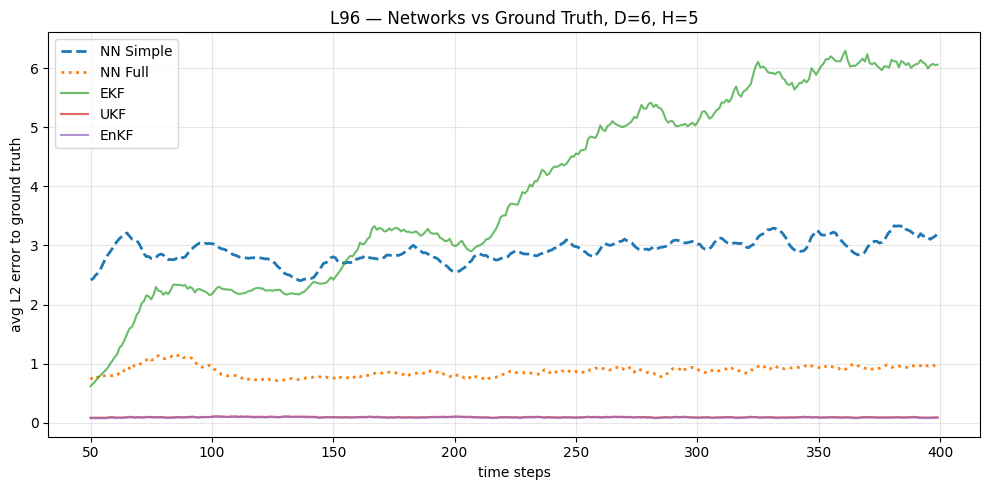

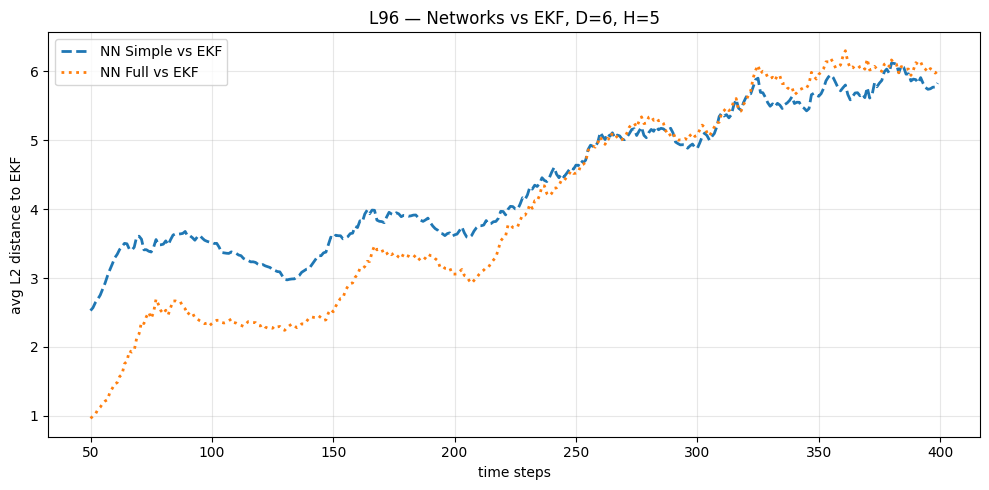

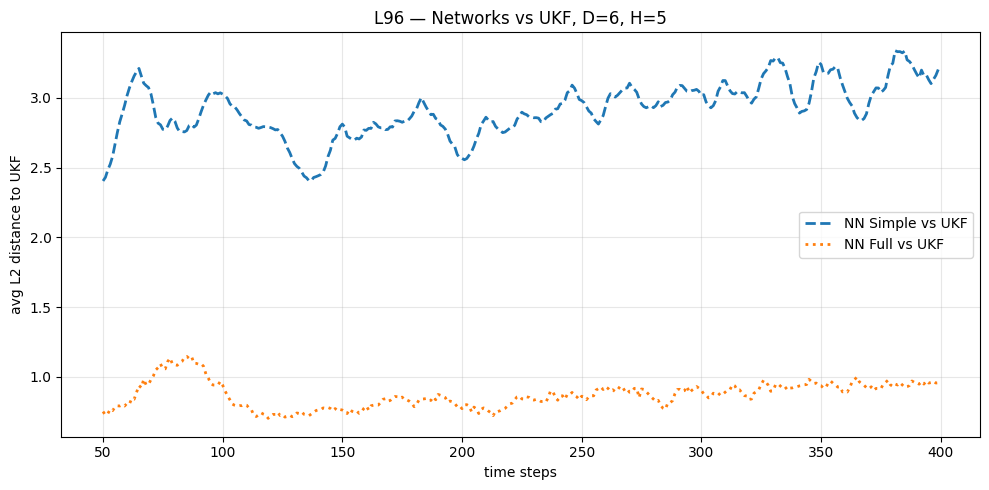

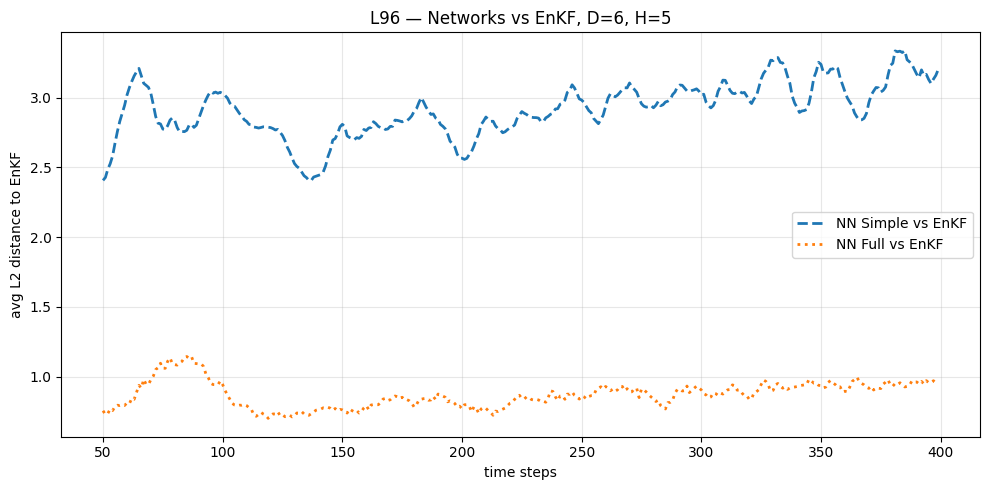

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(time, mean_err_s,    label="NN Simple", linewidth=2, linestyle="--")
plt.plot(time, mean_err_f,    label="NN Full",   linewidth=2, linestyle=":")
# (Optional: keep filters for context)
plt.plot(time, mean_err_ekf,  label="EKF",       linewidth=1.5, alpha=0.7)
plt.plot(time, mean_err_ukf,  label="UKF",       linewidth=1.5, alpha=0.7)
plt.plot(time, mean_err_enkf, label="EnKF",      linewidth=1.5, alpha=0.7)  # NEW
plt.grid(True, alpha=0.3)
plt.xlabel("time steps"); plt.ylabel("avg L2 error to ground truth")
plt.title(f"L96 — Networks vs Ground Truth, D={N}, H={History}")
plt.legend(); plt.tight_layout(); plt.show()

# Figure 2a: Networks' distance to EKF
plt.figure(figsize=(10, 5))
plt.plot(time, mean_d_s_ekf, label="NN Simple vs EKF", linewidth=2, linestyle="--")
plt.plot(time, mean_d_f_ekf, label="NN Full vs EKF",   linewidth=2, linestyle=":")
plt.grid(True, alpha=0.3)
plt.xlabel("time steps"); plt.ylabel("avg L2 distance to EKF")
plt.title(f"L96 — Networks vs EKF, D={N}, H={History}")
plt.legend(); plt.tight_layout(); plt.show()

# Figure 2b: Networks' distance to UKF
plt.figure(figsize=(10, 5))
plt.plot(time, mean_d_s_ukf, label="NN Simple vs UKF", linewidth=2, linestyle="--")
plt.plot(time, mean_d_f_ukf, label="NN Full vs UKF",   linewidth=2, linestyle=":")
plt.grid(True, alpha=0.3)
plt.xlabel("time steps"); plt.ylabel("avg L2 distance to UKF")
plt.title(f"L96 — Networks vs UKF, D={N}, H={History}")
plt.legend(); plt.tight_layout(); plt.show()

# Figure 2c: Networks' distance to EnKF
plt.figure(figsize=(10, 5))
plt.plot(time, mean_d_s_enkf, label="NN Simple vs EnKF", linewidth=2, linestyle="--")
plt.plot(time, mean_d_f_enkf, label="NN Full vs EnKF",   linewidth=2, linestyle=":")
plt.grid(True, alpha=0.3)
plt.xlabel("time steps"); plt.ylabel("avg L2 distance to EnKF")
plt.title(f"L96 — Networks vs EnKF, D={N}, H={History}")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
def _get(name, default=None):
    return globals().get(name, default)

# ---- pull metrics that were computed in your eval ----
metrics = []
if (v := _get("mean_err_s"))   is not None: metrics.append(("Neural Network (Simple)",    float(np.mean(v))))
if (v := _get("mean_err_f"))   is not None: metrics.append(("Neural Network (Full)",      float(np.mean(v))))
if (v := _get("mean_err_ekf")) is not None: metrics.append(("Extended Kalman Filter",      float(np.mean(v))))
if (v := _get("mean_err_ukf")) is not None: metrics.append(("Unscented Kalman Filter",     float(np.mean(v))))
if (v := _get("mean_err_enkf"))is not None: metrics.append(("Ensemble Kalman Filter",      float(np.mean(v))))

# ---- config recap (major knobs only; pulled from your setup) ----
cfg = {
    "State dimension (N)"                        : _get("N"),
    "Training sequence length (T)"               : _get("T"),
    "Evaluation sequence length (T_eval)"        : _get("T_eval"),
    "Training batch size (B)"                    : _get("B"),
    "History window (attention)"                 : _get("History"),
    "Training steps"                             : _get("steps"),
    "Lorenz–96 forcing (F)"                      : _get("F"),
    "Integration step (dt)"                      : _get("dt"),
    "Sensor exponent p in sign(x)·|x|^p"         : _get("p"),
    "Process covariance scale (diag Q)"          : float(_get("Q").diag().mean().item()) if _get("Q") is not None else None,
    "Measurement covariance scale (diag R)"      : float(_get("R").diag().mean().item()) if _get("R") is not None else None,
    "Ensemble size (EnKF)"                       : getattr(_get("enkf", None), "J", _get("J", None)),
    "Localization radius (EnKF)"                 : getattr(_get("enkf", None), "loc_radius", None),
    "Inflation factor (EnKF)"                    : getattr(_get("enkf", None), "infl", None),
    "Hidden dimension (NN Full)"                 : _get("hidden_dim"),
}

# ---- pretty print ----
def _fmt_row(left, right, w=50, prec=6):
    if right is None: return f"{left:<{w}} : n/a"
    if isinstance(right, float): return f"{left:<{w}} : {right:.{prec}f}"
    return f"{left:<{w}} : {right}"

bar = "="*88
sub = "-"*88

print(bar)
print("EVALUATION SUMMARY — Average L2 Error to Ground Truth".center(88))
print(bar)
for name, val in metrics:
    print(_fmt_row(name, val))
print(sub)

print("Configuration".center(88))
print(sub)
for k, v in cfg.items():
    print(_fmt_row(k, v))
print(bar)

                 EVALUATION SUMMARY — Average L2 Error to Ground Truth                  
Neural Network (Simple)                            : 2.913583
Neural Network (Full)                              : 0.873676
Extended Kalman Filter                             : 3.940617
Unscented Kalman Filter                            : 0.095265
Ensemble Kalman Filter                             : 0.087704
----------------------------------------------------------------------------------------
                                     Configuration                                      
----------------------------------------------------------------------------------------
State dimension (N)                                : 6
Training sequence length (T)                       : 400
Evaluation sequence length (T_eval)                : 400
Training batch size (B)                            : 1024
History window (attention)                         : 5
Training steps                                     :


=== Forcing F = 2.000 ===
Step 1/2500  Losses -> m1:6.805017 | m2:2.238951
Step 100/2500  Losses -> m1:4.100866 | m2:0.961361
Step 200/2500  Losses -> m1:2.478842 | m2:0.191797
Step 300/2500  Losses -> m1:1.517296 | m2:0.084991
Step 400/2500  Losses -> m1:0.949160 | m2:0.067605
Step 500/2500  Losses -> m1:0.620481 | m2:0.060881
Step 600/2500  Losses -> m1:0.418389 | m2:0.056286
Step 700/2500  Losses -> m1:0.302176 | m2:0.054519
Step 800/2500  Losses -> m1:0.226263 | m2:0.049804
Step 900/2500  Losses -> m1:0.176342 | m2:0.046647
Step 1000/2500  Losses -> m1:0.143622 | m2:0.044569
Step 1100/2500  Losses -> m1:0.121647 | m2:0.041917
Step 1200/2500  Losses -> m1:0.105566 | m2:0.039843
Step 1300/2500  Losses -> m1:0.095630 | m2:0.037966
Step 1400/2500  Losses -> m1:0.087079 | m2:0.036629
Step 1500/2500  Losses -> m1:0.082847 | m2:0.036175
Step 1600/2500  Losses -> m1:0.079894 | m2:0.034047
Step 1700/2500  Losses -> m1:0.076510 | m2:0.032753
Step 1800/2500  Losses -> m1:0.075461 | m2:0.0321

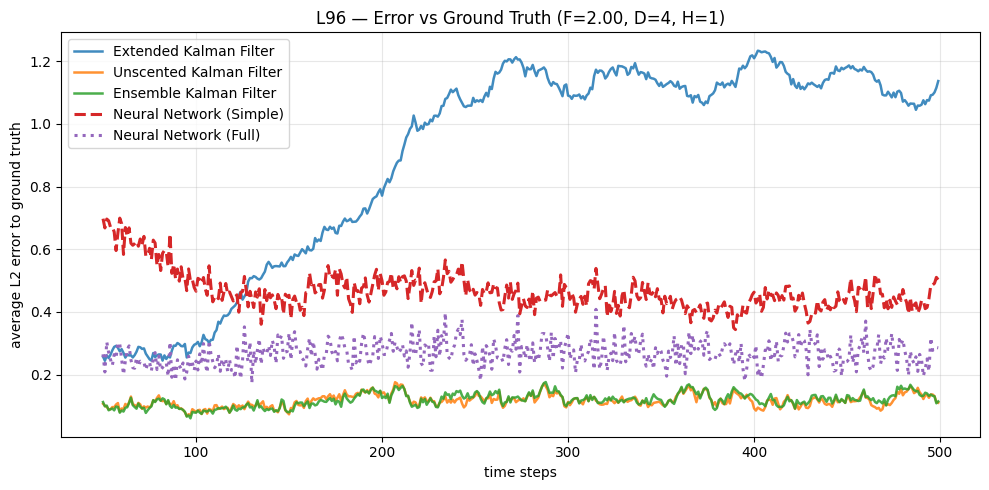


=== Forcing F = 4.000 ===
Step 1/2500  Losses -> m1:39.656914 | m2:7.105903
Step 100/2500  Losses -> m1:21.794365 | m2:2.376909
Step 200/2500  Losses -> m1:11.835340 | m2:0.652370
Step 300/2500  Losses -> m1:6.227224 | m2:0.334943
Step 400/2500  Losses -> m1:3.198423 | m2:0.220269
Step 500/2500  Losses -> m1:1.657234 | m2:0.168923
Step 600/2500  Losses -> m1:0.909867 | m2:0.143483
Step 700/2500  Losses -> m1:0.572710 | m2:0.128918
Step 800/2500  Losses -> m1:0.422705 | m2:0.118816
Step 900/2500  Losses -> m1:0.358392 | m2:0.111521
Step 1000/2500  Losses -> m1:0.334145 | m2:0.107924
Step 1100/2500  Losses -> m1:0.321144 | m2:0.100074
Step 1200/2500  Losses -> m1:0.318527 | m2:0.095876
Step 1300/2500  Losses -> m1:0.316540 | m2:0.090984
Step 1400/2500  Losses -> m1:0.315733 | m2:0.086906
Step 1500/2500  Losses -> m1:0.313512 | m2:0.083499
Step 1600/2500  Losses -> m1:0.313458 | m2:0.079309
Step 1700/2500  Losses -> m1:0.312742 | m2:0.076833
Step 1800/2500  Losses -> m1:0.313053 | m2:0.0

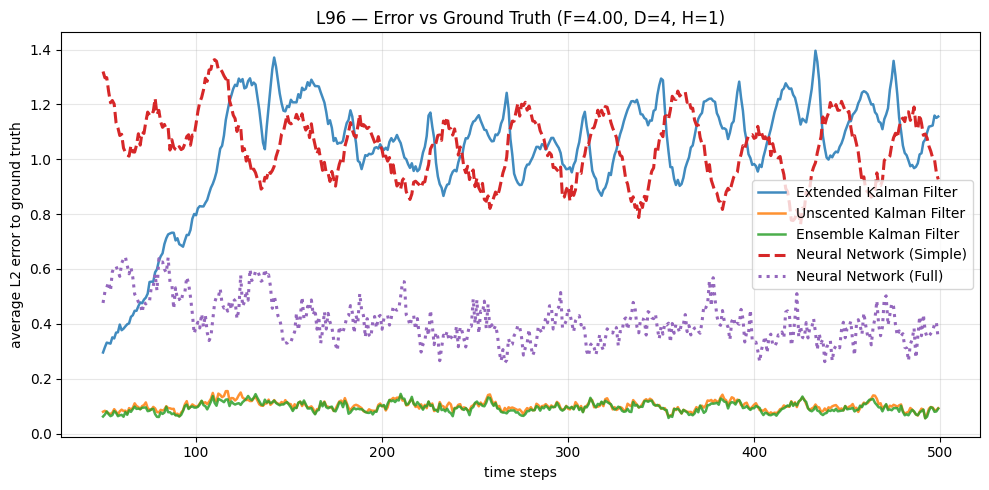


=== Forcing F = 6.000 ===
Step 1/2500  Losses -> m1:89.820992 | m2:12.633311
Step 100/2500  Losses -> m1:45.051525 | m2:4.026395
Step 200/2500  Losses -> m1:23.424263 | m2:2.163587
Step 300/2500  Losses -> m1:12.202868 | m2:0.941177
Step 400/2500  Losses -> m1:6.397539 | m2:0.632865
Step 500/2500  Losses -> m1:3.344175 | m2:0.520278
Step 600/2500  Losses -> m1:1.863988 | m2:0.432016
Step 700/2500  Losses -> m1:1.175746 | m2:0.358685
Step 800/2500  Losses -> m1:0.890696 | m2:0.319624
Step 900/2500  Losses -> m1:0.778123 | m2:0.256545
Step 1000/2500  Losses -> m1:0.741256 | m2:0.233319
Step 1100/2500  Losses -> m1:0.730103 | m2:0.219288
Step 1200/2500  Losses -> m1:0.721320 | m2:0.203570
Step 1300/2500  Losses -> m1:0.725989 | m2:0.194920
Step 1400/2500  Losses -> m1:0.719568 | m2:0.180751
Step 1500/2500  Losses -> m1:0.722287 | m2:0.173421
Step 1600/2500  Losses -> m1:0.717297 | m2:0.162792
Step 1700/2500  Losses -> m1:0.720259 | m2:0.159475
Step 1800/2500  Losses -> m1:0.717834 | m2:0

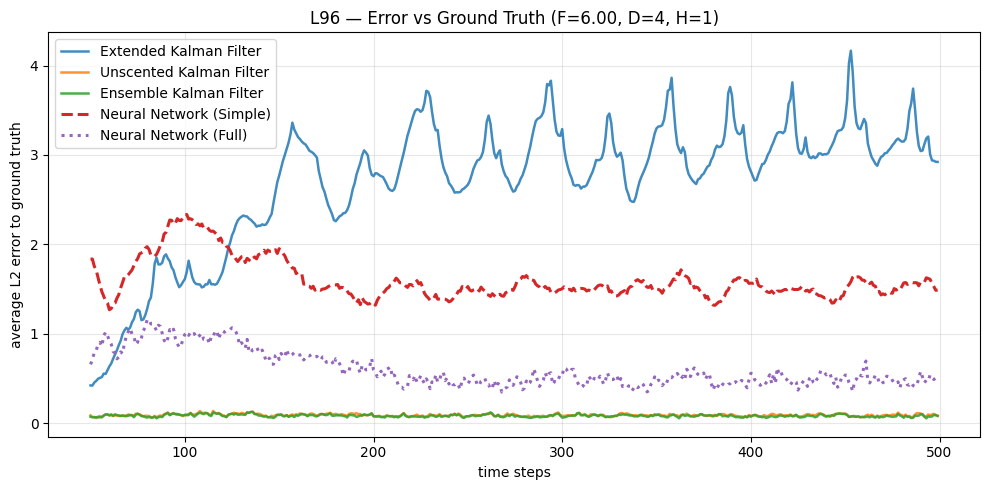


=== Forcing F = 8.000 ===
Step 1/2500  Losses -> m1:283.289581 | m2:25.024010
Step 100/2500  Losses -> m1:148.744446 | m2:10.915647
Step 200/2500  Losses -> m1:75.405357 | m2:2.568652
Step 300/2500  Losses -> m1:36.421940 | m2:1.403674
Step 400/2500  Losses -> m1:17.062939 | m2:0.927924
Step 500/2500  Losses -> m1:8.092190 | m2:0.681268
Step 600/2500  Losses -> m1:4.047720 | m2:0.559722
Step 700/2500  Losses -> m1:2.345958 | m2:0.485861
Step 800/2500  Losses -> m1:1.659752 | m2:0.439141
Step 900/2500  Losses -> m1:1.408938 | m2:0.393846
Step 1000/2500  Losses -> m1:1.307293 | m2:0.360196
Step 1100/2500  Losses -> m1:1.270350 | m2:0.313772
Step 1200/2500  Losses -> m1:1.266653 | m2:0.298188
Step 1300/2500  Losses -> m1:1.269134 | m2:0.286758
Step 1400/2500  Losses -> m1:1.262488 | m2:0.273246
Step 1500/2500  Losses -> m1:1.264541 | m2:0.267652
Step 1600/2500  Losses -> m1:1.268092 | m2:0.264309
Step 1700/2500  Losses -> m1:1.262959 | m2:0.246856
Step 1800/2500  Losses -> m1:1.264658 | 

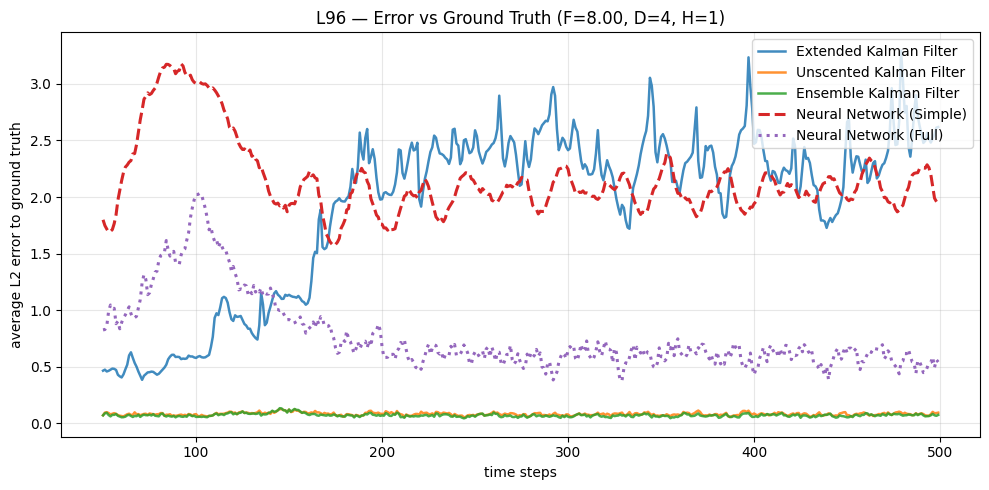


=== Forcing F = 10.000 ===
Step 1/2500  Losses -> m1:485.468628 | m2:57.747257
Step 100/2500  Losses -> m1:247.764542 | m2:23.224569
Step 200/2500  Losses -> m1:125.885925 | m2:20.240774
Step 300/2500  Losses -> m1:61.886650 | m2:17.618319
Step 400/2500  Losses -> m1:29.590134 | m2:15.107325
Step 500/2500  Losses -> m1:14.107833 | m2:9.933192
Step 600/2500  Losses -> m1:6.881796 | m2:5.094461
Step 700/2500  Losses -> m1:3.894619 | m2:4.797084
Step 800/2500  Losses -> m1:2.652106 | m2:4.619370
Step 900/2500  Losses -> m1:2.213225 | m2:4.475913
Step 1000/2500  Losses -> m1:2.063434 | m2:4.366623
Step 1100/2500  Losses -> m1:2.021064 | m2:4.284038
Step 1200/2500  Losses -> m1:2.008955 | m2:4.173550
Step 1300/2500  Losses -> m1:2.004097 | m2:4.084580
Step 1400/2500  Losses -> m1:1.992333 | m2:4.000407
Step 1500/2500  Losses -> m1:2.004710 | m2:3.869525
Step 1600/2500  Losses -> m1:1.999627 | m2:3.782121
Step 1700/2500  Losses -> m1:2.001965 | m2:3.642746
Step 1800/2500  Losses -> m1:2.000

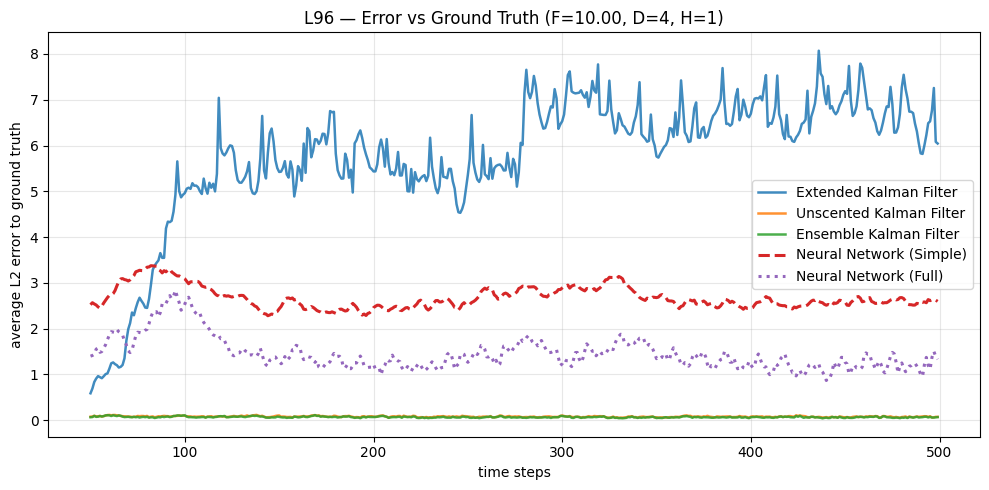


=== Forcing F = 12.000 ===
Step 1/2500  Losses -> m1:1146.935303 | m2:29.707960
Step 100/2500  Losses -> m1:613.030212 | m2:7.857435
Step 200/2500  Losses -> m1:330.519623 | m2:3.464065
Step 300/2500  Losses -> m1:171.606628 | m2:2.365554
Step 400/2500  Losses -> m1:87.333176 | m2:1.817487
Step 500/2500  Losses -> m1:42.827137 | m2:1.494116
Step 600/2500  Losses -> m1:20.724676 | m2:1.207211
Step 700/2500  Losses -> m1:10.431069 | m2:1.081127
Step 800/2500  Losses -> m1:5.879078 | m2:0.964099
Step 900/2500  Losses -> m1:4.055679 | m2:0.890665
Step 1000/2500  Losses -> m1:3.351874 | m2:0.818825
Step 1100/2500  Losses -> m1:3.122669 | m2:0.771453
Step 1200/2500  Losses -> m1:3.044921 | m2:0.730176
Step 1300/2500  Losses -> m1:3.012778 | m2:0.661689
Step 1400/2500  Losses -> m1:3.013412 | m2:0.641775
Step 1500/2500  Losses -> m1:3.006547 | m2:0.613018
Step 1600/2500  Losses -> m1:3.005245 | m2:0.587142
Step 1700/2500  Losses -> m1:3.009672 | m2:0.577040
Step 1800/2500  Losses -> m1:3.012

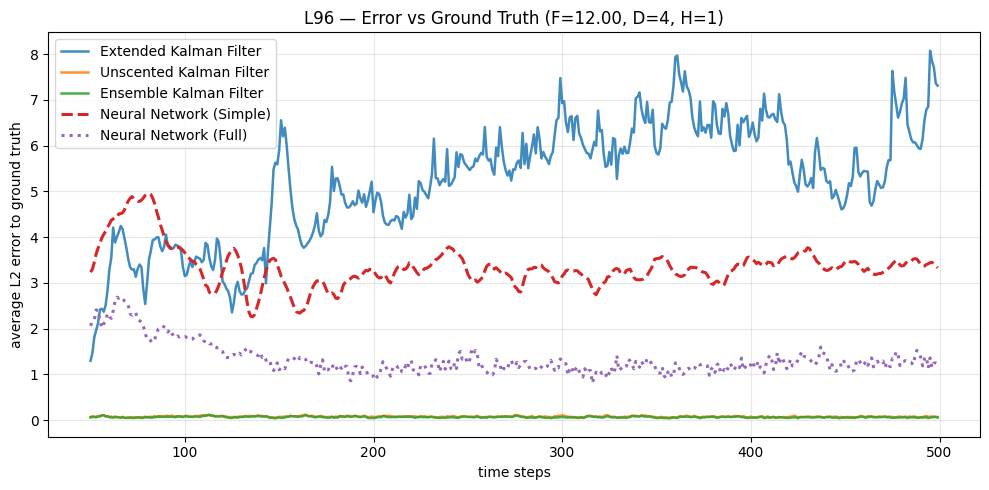


=== Forcing F = 14.000 ===
Step 1/2500  Losses -> m1:1136.758423 | m2:69.345375
Step 100/2500  Losses -> m1:536.245667 | m2:27.272549
Step 200/2500  Losses -> m1:233.520081 | m2:19.155691
Step 300/2500  Losses -> m1:93.794586 | m2:7.253078
Step 400/2500  Losses -> m1:36.394470 | m2:3.313848
Step 500/2500  Losses -> m1:14.780579 | m2:2.307419
Step 600/2500  Losses -> m1:7.379684 | m2:1.973493
Step 700/2500  Losses -> m1:5.033392 | m2:1.754635
Step 800/2500  Losses -> m1:4.304614 | m2:1.651549
Step 900/2500  Losses -> m1:4.107864 | m2:1.556137
Step 1000/2500  Losses -> m1:4.062434 | m2:1.479942
Step 1100/2500  Losses -> m1:4.032343 | m2:1.400922
Step 1200/2500  Losses -> m1:4.031029 | m2:1.335760
Step 1300/2500  Losses -> m1:4.034878 | m2:1.274390
Step 1400/2500  Losses -> m1:4.030728 | m2:1.221688
Step 1500/2500  Losses -> m1:4.043983 | m2:1.188281
Step 1600/2500  Losses -> m1:4.036844 | m2:1.129180
Step 1700/2500  Losses -> m1:4.038449 | m2:1.107878
Step 1800/2500  Losses -> m1:4.0384

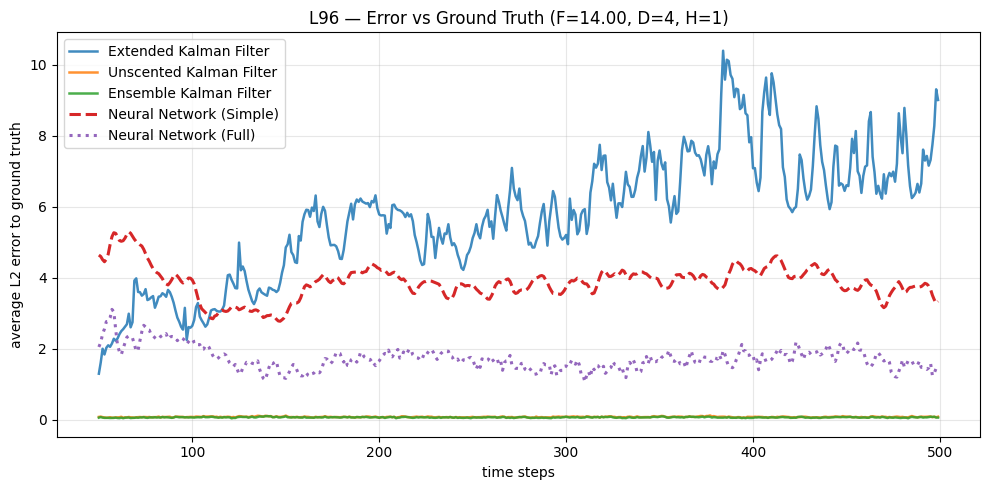


=== Forcing F = 16.000 ===
Step 1/2500  Losses -> m1:1417.535767 | m2:49.063580
Step 100/2500  Losses -> m1:682.988647 | m2:19.822783
Step 200/2500  Losses -> m1:315.332245 | m2:9.398046
Step 300/2500  Losses -> m1:134.055115 | m2:6.978333
Step 400/2500  Losses -> m1:53.418308 | m2:5.513618
Step 500/2500  Losses -> m1:21.396330 | m2:4.158140
Step 600/2500  Losses -> m1:9.872500 | m2:3.509963
Step 700/2500  Losses -> m1:6.253264 | m2:3.100854
Step 800/2500  Losses -> m1:5.266764 | m2:2.809444
Step 900/2500  Losses -> m1:5.023256 | m2:2.588001
Step 1000/2500  Losses -> m1:4.978881 | m2:2.308372
Step 1100/2500  Losses -> m1:4.971999 | m2:2.013812
Step 1200/2500  Losses -> m1:4.963018 | m2:1.767147
Step 1300/2500  Losses -> m1:4.947782 | m2:1.525634
Step 1400/2500  Losses -> m1:4.944964 | m2:1.388051
Step 1500/2500  Losses -> m1:4.958302 | m2:1.319809
Step 1600/2500  Losses -> m1:4.947339 | m2:1.261223
Step 1700/2500  Losses -> m1:4.962422 | m2:1.208255
Step 1800/2500  Losses -> m1:4.9664

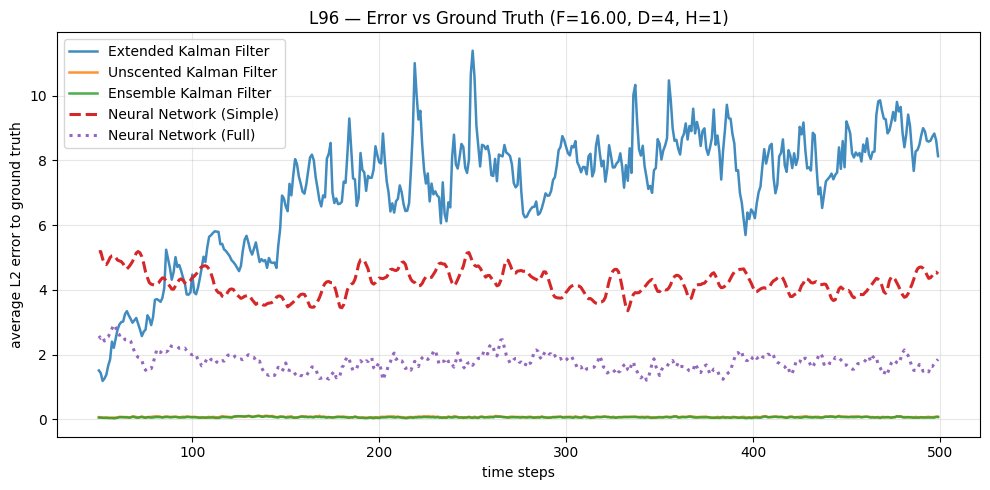

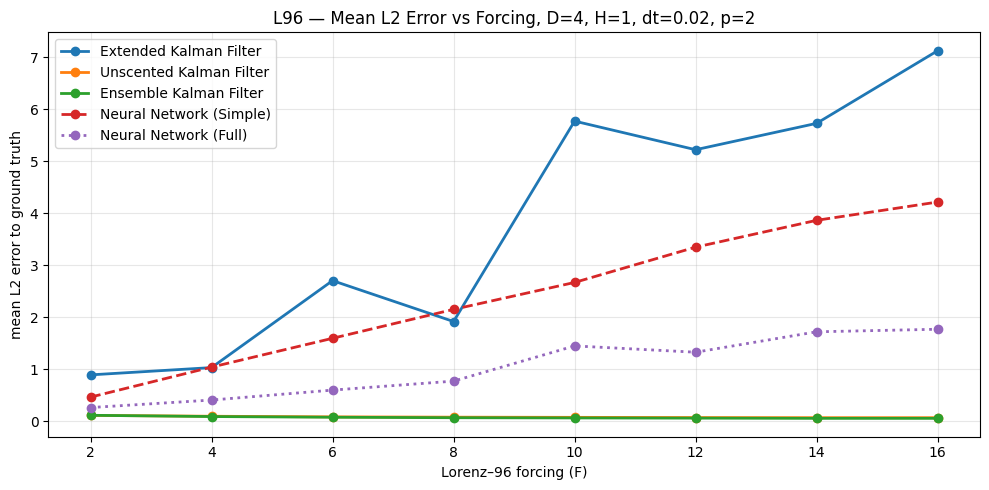

Saved scalar results to l96_sweep_F_results.npz
Saved per-F time-series to l96_sweep_F_timeseries.npz


In [ ]:
torch.manual_seed(0); np.random.seed(0)

T = 500
N = 4
M = N
B = 2**10
History = 1
steps = 2500
dt = 0.02
p  = 2
Batch_Multiplier = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32

# Covariances and measurement map
Q = (1e-3) * torch.eye(N, device=device, dtype=dtype)
R = (5e-2) * torch.eye(M, device=device, dtype=dtype)
H = torch.zeros(M, N, device=device, dtype=dtype); H[:, :M] = torch.eye(M, device=device, dtype=dtype)
P0 = torch.eye(N, device=device, dtype=dtype)

# Eval config
T_eval      = T
B_eval      = 10
outer_loops = 1
transient_drop = 50  # steps to skip when averaging

# Forcing values to sweep
F_values = np.linspace(2.0, 16.0, 8)  # 8 values: 2,4,...,16

# Storage for scalar accuracy vs F
acc_vsF = {
    "F": [],
    "NN_Simple": [],
    "NN_Full": [],
    "EKF": [],
    "UKF": [],
    "EnKF": [],
}

# Optional: keep per-F time series (mean L2 over batch) if you want to inspect later
perF_timeseries = {}

# =========================
# Sweep over F
# =========================
for F in F_values:
    print(f"\n=== Forcing F = {F:.3f} ===")

    # ----- Simulator & Filters for this F -----
    sim = L96Simulator(Q=Q, H=H, R=R, F=float(F), dt=dt, substeps=1, p=p)

    ekf = ExtendedKalmanFilterL96(
        dt=dt, F=float(F), H=H.cpu().numpy(),
        Q=Q.cpu().numpy(), R=R.cpu().numpy(), P0=P0.cpu().numpy(), p=p
    )
    ukf = UnscentedKalmanFilterL96(
        dt=dt, F=float(F), H=H.cpu().numpy(),
        Q=Q.cpu().numpy(), R=R.cpu().numpy(), P0=P0.cpu().numpy(), p=p,
        alpha=1e-3, beta=2.0, kappa=0.0
    )
    enkf = EnsembleKalmanFilterL96(
        dt=dt, F=float(F),
        H=H.cpu().numpy(), Q=Q.cpu().numpy(), R=R.cpu().numpy(),
        P0=P0.cpu().numpy(), J=50, p=p
    )

    # ----- Models (fresh per F) -----
    hidden_dim = 2 * N
    network_simple = NN_Kalman_Simple(dim=N, H=History, device=device).to(device)
    network_full   = NN_Kalman_Full(dim=N, H=History, hidden_dim=hidden_dim, device=device).to(device)

    # ----- Train both neural networks on this simulator -----
    train([network_simple, network_full], sim, steps, B, Batch_Multiplier, device)

    # ----- Evaluate: per-time mean L2 error to GT for each model -----
    # Accumulate across 'outer_loops' micro-batches
    sum_err_ekf  = torch.zeros(T_eval, device=device, dtype=dtype)
    sum_err_ukf  = torch.zeros(T_eval, device=device, dtype=dtype)
    sum_err_enkf = torch.zeros(T_eval, device=device, dtype=dtype)
    sum_err_s    = torch.zeros(T_eval, device=device, dtype=dtype)
    sum_err_f    = torch.zeros(T_eval, device=device, dtype=dtype)
    total_series = 0

    network_simple.eval(); network_full.eval()

    with torch.no_grad():
        for _ in range(outer_loops):
            X_true_eval, Y_eval, x0_eval = sim(T=T_eval, B=B_eval, device=device)

            # Filters (NumPy/CPU)
            Y_np, x0_np = Y_eval.cpu().numpy(), x0_eval.cpu().numpy()
            X_ekf_np,  _, _, _, _ = ekf(Y_np,  x0_np)
            X_ukf_np,  _, _, _, _ = ukf(Y_np,  x0_np)
            X_enkf_np, _, _, _, _ = enkf(Y_np, x0_np)

            # Back to Torch on device
            X_ekf  = torch.from_numpy(X_ekf_np).to(device)
            X_ukf  = torch.from_numpy(X_ukf_np).to(device)
            X_enkf = torch.from_numpy(X_enkf_np).to(device)

            # NNs
            X_s = network_simple(Y_eval)
            X_f = network_full(Y_eval)

            # Per-seq errors to GT, then sum over batch
            sum_err_ekf  += (X_ekf  - X_true_eval).norm(dim=-1).sum(dim=0)
            sum_err_ukf  += (X_ukf  - X_true_eval).norm(dim=-1).sum(dim=0)
            sum_err_enkf += (X_enkf - X_true_eval).norm(dim=-1).sum(dim=0)
            sum_err_s    += (X_s    - X_true_eval).norm(dim=-1).sum(dim=0)
            sum_err_f    += (X_f    - X_true_eval).norm(dim=-1).sum(dim=0)

            total_series += B_eval

    # Mean over batch, then drop transient
    sl = slice(transient_drop, None)
    time_axis = np.arange(T_eval)[sl]

    mean_err_ekf  = (sum_err_ekf  / total_series).detach().cpu().numpy()[sl]
    mean_err_ukf  = (sum_err_ukf  / total_series).detach().cpu().numpy()[sl]
    mean_err_enkf = (sum_err_enkf / total_series).detach().cpu().numpy()[sl]
    mean_err_s    = (sum_err_s    / total_series).detach().cpu().numpy()[sl]
    mean_err_f    = (sum_err_f    / total_series).detach().cpu().numpy()[sl]

    # Store time series for this F (optional)
    perF_timeseries[float(F)] = dict(
        time=time_axis,
        nn_simple=mean_err_s,
        nn_full=mean_err_f,
        ekf=mean_err_ekf,
        ukf=mean_err_ukf,
        enkf=mean_err_enkf,
    )

    # Plot per-F time series (each model vs ground truth)
    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, mean_err_ekf,  label="Extended Kalman Filter", linewidth=1.8, alpha=0.85)
    plt.plot(time_axis, mean_err_ukf,  label="Unscented Kalman Filter", linewidth=1.8, alpha=0.85)
    plt.plot(time_axis, mean_err_enkf, label="Ensemble Kalman Filter",  linewidth=1.8, alpha=0.85)
    plt.plot(time_axis, mean_err_s,    label="Neural Network (Simple)", linewidth=2.2, linestyle="--")
    plt.plot(time_axis, mean_err_f,    label="Neural Network (Full)",   linewidth=2.2, linestyle=":")
    plt.grid(True, alpha=0.3)
    plt.xlabel("time steps")
    plt.ylabel("average L2 error to ground truth")
    plt.title(f"L96 — Error vs Ground Truth (F={F:.2f}, D={N}, H={History})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Aggregate scalar accuracy (mean over remaining time)
    acc_vsF["F"].append(float(F))
    acc_vsF["NN_Simple"].append(float(np.mean(mean_err_s)))
    acc_vsF["NN_Full"].append(float(np.mean(mean_err_f)))
    acc_vsF["EKF"].append(float(np.mean(mean_err_ekf)))
    acc_vsF["UKF"].append(float(np.mean(mean_err_ukf)))
    acc_vsF["EnKF"].append(float(np.mean(mean_err_enkf)))

# =========================
# Final: accuracy vs F plot
# =========================
Fs = np.array(acc_vsF["F"])
plt.figure(figsize=(10, 5))
plt.plot(Fs, acc_vsF["EKF"],      marker="o", linewidth=2, label="Extended Kalman Filter")
plt.plot(Fs, acc_vsF["UKF"],      marker="o", linewidth=2, label="Unscented Kalman Filter")
plt.plot(Fs, acc_vsF["EnKF"],     marker="o", linewidth=2, label="Ensemble Kalman Filter")
plt.plot(Fs, acc_vsF["NN_Simple"],marker="o", linewidth=2, linestyle="--", label="Neural Network (Simple)")
plt.plot(Fs, acc_vsF["NN_Full"],  marker="o", linewidth=2, linestyle=":",  label="Neural Network (Full)")
plt.grid(True, alpha=0.3)
plt.xlabel("Lorenz–96 forcing (F)")
plt.ylabel("mean L2 error to ground truth")
plt.title(f"L96 — Mean L2 Error vs Forcing, D={N}, H={History}, dt={dt}, p={p}")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# Save results
# =========================
# Scalars vs F + optionally per-F time series
np.savez(
    "l96_sweep_F_results.npz",
    F=Fs,
    err_EKF=np.array(acc_vsF["EKF"]),
    err_UKF=np.array(acc_vsF["UKF"]),
    err_EnKF=np.array(acc_vsF["EnKF"]),
    err_NN_Simple=np.array(acc_vsF["NN_Simple"]),
    err_NN_Full=np.array(acc_vsF["NN_Full"]),
)

print("Saved scalar results to l96_sweep_F_results.npz")

# (Optional) save per-F time series too, as a separate NPZ
# Flatten into a dict of arrays with composite keys
ts_dump = {"F": Fs}
for F in Fs:
    rec = perF_timeseries[float(F)]
    ts_dump[f"time_F{F:.2f}"]       = rec["time"]
    ts_dump[f"ekf_F{F:.2f}"]        = rec["ekf"]
    ts_dump[f"ukf_F{F:.2f}"]        = rec["ukf"]
    ts_dump[f"enkf_F{F:.2f}"]       = rec["enkf"]
    ts_dump[f"nn_simple_F{F:.2f}"]  = rec["nn_simple"]
    ts_dump[f"nn_full_F{F:.2f}"]    = rec["nn_full"]

np.savez("l96_sweep_F_timeseries.npz", **ts_dump)
print("Saved per-F time-series to l96_sweep_F_timeseries.npz")

In [10]:
import numpy as np
from scipy.special import kv, gamma
x=[5,10,15]
sigma2=1.0
ell=1.0
nu=.1
x = np.asarray(x, float)
D = np.abs(np.subtract.outer(x, x))
if nu == 0.5:  # exponential kernel
    K = np.exp(-D / ell)
else:
    z = np.sqrt(2*nu) * D / ell
    # safe at z=0: limit -> 1
    K = (2**(1-nu) / gamma(nu)) * (z**nu) * kv(nu, np.where(z==0, 1e-12, z))
    K[z==0] = 1.0
sigma2 * K

array([[1.        , 0.01820311, 0.00150535],
       [0.01820311, 1.        , 0.01820311],
       [0.00150535, 0.01820311, 1.        ]])